### Forecast de demanda: Facturapp

### ✅ Prophet

##### Datos

In [3]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [4]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [5]:
# Asegúrate de que 'monto_ventas_producto' sea numérico
ventas_df['monto_ventas_producto'] = pd.to_numeric(ventas_df['cantidad_ventas_producto'], errors='coerce')

# Agrupa por tipo de moneda y suma los montos de ventas
suma_por_moneda = ventas_df.groupby('moneda_venta')['cantidad_ventas_producto'].sum()

# Calcular el total de todas las ventas
total_ventas = suma_por_moneda.sum()

# Crear un nuevo DataFrame con los montos y los porcentajes
resultado = pd.DataFrame({
    'Monto Total': suma_por_moneda,
    'Porcentaje del Total': (suma_por_moneda / total_ventas) * 100
})

# Formatear los montos y porcentajes para mejor legibilidad
resultado['Monto Total'] = resultado['Monto Total'].apply(lambda x: f"{x:,.2f}")
resultado['Porcentaje del Total'] = resultado['Porcentaje del Total'].apply(lambda x: f"{x:.2f}%")

# Verificar el resultado
resultado


,Monto Total,Porcentaje del Total
moneda_venta,,
$,"1,460,236.00",99.99%
U$S,140.00,0.01%


Conclusión: Nuestro primer pronóstico agregado va a ser sólo para moneda_venta = $.

In [268]:
# Ver los valores únicos en la columna 'moneda_venta'
print(ventas_df['moneda_venta'].unique())


['$  ' 'U$S']


In [239]:
# Filtrar por tipo de moneda (por ejemplo, solo $)
ventas_filtrado = ventas_df.loc[ventas_df['moneda_venta'] == '$  ']

# Crear la tabla agregada con el DataFrame filtrado
df_prophet = ventas_filtrado.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que Prophet tome como input
df = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})

# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Revisar los datos resampleados
df.head()


,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


##### Variables exógenas

In [242]:
# Asegúrate de que la columna 'ds' sea de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Variables exógenes: Crear la nueva columna 'end_of_day' y 'end_of_month'
#df['end_of_week'] = df['ds'].apply(lambda x: 1 if x.dayofweek == 6 else 0) # como lo pasamos semanal ya no tiene sentido
df['end_of_month'] = df['ds'].apply(lambda x: 1 if x.is_month_end else 0)

In [269]:
df.head()

,ds,y,end_of_month
0,2022-04-24,8571.829,0
1,2022-05-01,7043.764,1
2,2022-05-08,10131.486,0
3,2022-05-15,8331.784,0
4,2022-05-22,7913.856,0


##### Para modelar vacaciones y eventos especiales con selección manual

In [243]:
import pandas as pd

# Lista de los nombres de los feriados
holiday_names = ['Año Nuevo', 'Reyes', 'Carnaval', 'Semana Santa', 'Día del Trabajador', 'Natalicio de Artigas', 
                 'Jura de la Constitución', 'Declaratoria de la Independencia', 'Día de la Raza', 'Día de los Difuntos', 'Navidad']

# Fechas base de los feriados (solo un año de ejemplo, luego generaremos para otros años)
holiday_dates = ['01-01', '01-06', '02-12', '03-28', '05-01', '06-19', '07-18', '08-25', '10-12', '11-02', '12-25']

# Crear una lista vacía para almacenar los feriados
all_holidays = []

# Generar los feriados para los años desde 2022 hasta 2026
for year in range(2022, 2027):
    for i, date in enumerate(holiday_dates):
        all_holidays.append({
            'holiday': holiday_names[i],
            'ds': pd.to_datetime(f'{year}-{date}'),
            'lower_window': -3,  # Afecta 3 días antes del feriado
            'upper_window': 3    # Afecta 3 días después del feriado
        })

# Convertir la lista de diccionarios a un DataFrame de pandas
holidays_uruguay = pd.DataFrame(all_holidays)

# Mostrar los primeros datos
holidays_uruguay.head(11)


,holiday,ds,lower_window,upper_window
0,Año Nuevo,2022-01-01,-3,3
1,Reyes,2022-01-06,-3,3
2,Carnaval,2022-02-12,-3,3
3,Semana Santa,2022-03-28,-3,3
4,Día del Trabajador,2022-05-01,-3,3
5,Natalicio de Artigas,2022-06-19,-3,3
6,Jura de la Constitución,2022-07-18,-3,3
7,Declaratoria de la Independencia,2022-08-25,-3,3
8,Día de la Raza,2022-10-12,-3,3
9,Día de los Difuntos,2022-11-02,-3,3


##### Resamplear los datos de diario a semanal

In [246]:
# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Resamplear los datos de diario a semanal y sumar todas las columnas
df = df.set_index('ds').resample('W').agg({
    'y': 'sum',                  # Sumar ventas
    'end_of_month': 'sum'        # Sumar indicadores de fin de mes
}).reset_index()

# La primera y última fila posiblemente están incompletas, así que las eliminamos
df = df.iloc[1:-1].reset_index(drop=True)

# Revisar los datos resampleados
df.head()

,ds,y,end_of_month
0,2022-04-24,8571.829,0
1,2022-05-01,7043.764,1
2,2022-05-08,10131.486,0
3,2022-05-15,8331.784,0
4,2022-05-22,7913.856,0


In [240]:
import plotly.express as px

px.line(df, x='ds', y='y',title="Forecast de demanda Facturapp")

In [247]:
import plotly.express as px

px.line(df, x='ds', y='y',title="Forecast de demanda Facturapp")

##### Train y test set

In [249]:
TEST_DATE = '2024-01-15'

df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]


print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)),2)*100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)),2)*100, "%")

Datos de training:  91  -  83.0 %
Datos de testing:  19  -  17.0 %


##### Training, CV and metrics

22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape     smape  coverage
0  4 days  1.364129e+06  1167.959119   885.251360  0.058309  0.058309  0.055490       1.0
1  6 days  7.773491e+06  2788.098063  2614.789653  0.179652  0.179652  0.162932       0.5
2  8 days  9.818658e+06  3133.473820  3095.388432  0.220170  0.220170  0.198011       0.0
3 11 days  4.144075e+06  2035.700104  1913.421142  0.133555  0.133555  0.123866       0.5
4 13 days  1.037292e+07  3220.702041  2803.628989  0.211300  0.211300  0.184388       0.5
Mejor MSE: 8715394.88
Mejor RMSE: 2752.74
Mejor MAPE: 0.18 %


22:56:26 - cmdstanpy - INFO - Chain [1] start processing
22:56:36 - cmdstanpy - INFO - Chain [1] done processing


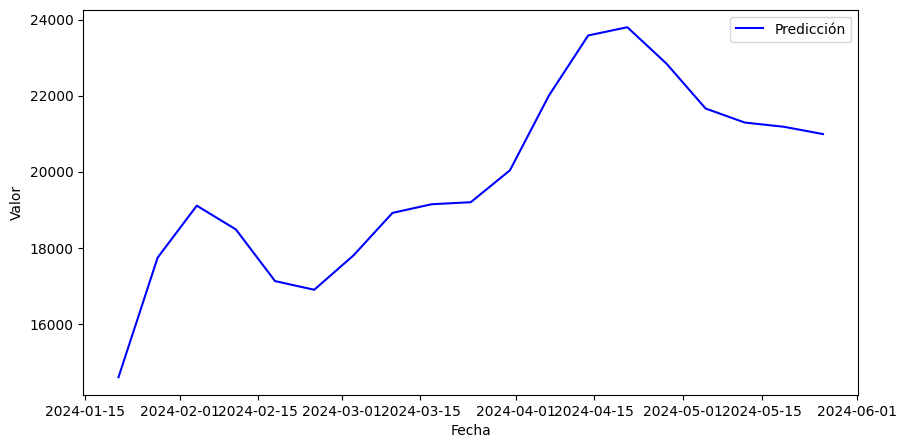

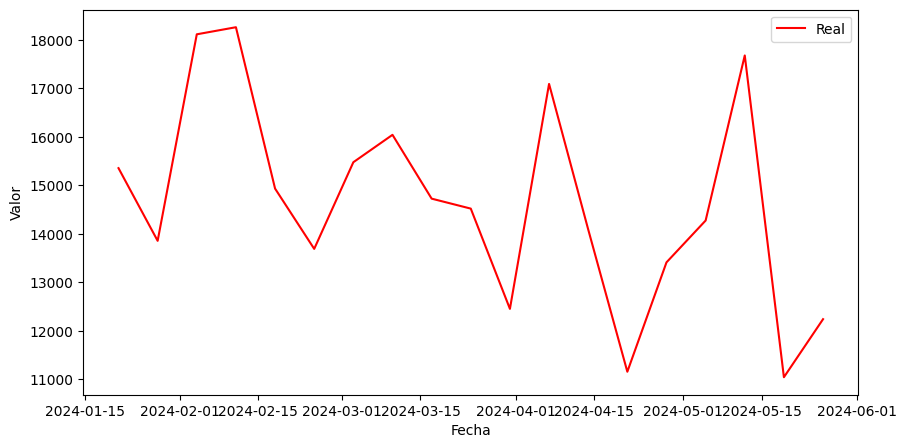

In [266]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Función para realizar Grid Search en Prophet con todos los parámetros posibles
def prophet_grid_search(df_train, df_test, param_grid):
    # Lista para almacenar los resultados
    results = []
    
    # Generar todas las combinaciones posibles de los parámetros
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    # Iterar sobre cada combinación de parámetros
    for params in all_params:
        # Crear el modelo Prophet con los parámetros actuales
        m = Prophet(
            growth=params['growth'],
            changepoints=params['changepoints'],
            n_changepoints=params['n_changepoints'],
            changepoint_range=params['changepoint_range'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            daily_seasonality=params['daily_seasonality'],
            holidays=params['holidays'],
            seasonality_mode=params['seasonality_mode'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            mcmc_samples=params['mcmc_samples'],
            interval_width=params['interval_width'],
            uncertainty_samples=params['uncertainty_samples'],
            stan_backend=params['stan_backend']
        )

        # Agregar regresores
        m.add_regressor('end_of_month')

        # Entrenar el modelo
        m.fit(df_train)

        # Validación cruzada sobre el modelo entrenado
        df_cv = cross_validation(m, initial='500 days', period='30 days', horizon='60 days', parallel="processes")

        # Calcular métricas de rendimiento
        df_performance = performance_metrics(df_cv)
        print(df_performance.head())
        
        # Obtener MSE, RMSE, MAPE
        mse = df_performance['mse'].mean()
        rmse = df_performance['rmse'].mean()
        mape = df_performance['mape'].mean()

        # Guardar los resultados (parámetros, MSE, RMSE, MAPE)
        results.append((params, mse, rmse, mape))
    
    # Ordenar los resultados por MAPE (menor es mejor)
    results = sorted(results, key=lambda x: x[3])  # Ordenar por MAPE
    
    # Mostrar la mejor combinación de parámetros
    best_params, best_mse, best_rmse, best_mape = results[0]
    print(f"Mejor MSE: {round(best_mse, 2)}")
    print(f"Mejor RMSE: {round(best_rmse, 2)}")
    print(f"Mejor MAPE: {round(best_mape, 2)} %")
    
    # Entrenar el modelo final con los mejores parámetros
    best_model = Prophet(
        growth=best_params['growth'],
        changepoints=best_params['changepoints'],
        n_changepoints=best_params['n_changepoints'],
        changepoint_range=best_params['changepoint_range'],
        yearly_seasonality=best_params['yearly_seasonality'],
        weekly_seasonality=best_params['weekly_seasonality'],
        daily_seasonality=best_params['daily_seasonality'],
        holidays=best_params['holidays'],
        seasonality_mode=best_params['seasonality_mode'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        mcmc_samples=best_params['mcmc_samples'],
        interval_width=best_params['interval_width'],
        uncertainty_samples=best_params['uncertainty_samples'],
        stan_backend=best_params['stan_backend']
    )

    # Agregar regresores
    best_model.add_regressor('end_of_month')    

    # Entrenar el modelo final
    best_model.fit(df_train)

    # Predicción en el conjunto de prueba
    forecast = best_model.predict(df_test)

    # Gráfico de la predicción vs los datos reales
    plt.figure(figsize=(10, 5))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicción', color='blue')
    #plt.plot(df_test['ds'], df_test['y'], label='Real', color='red')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()


    plt.figure(figsize=(10, 5))
    #plt.plot(forecast['ds'], forecast['yhat'], label='Predicción', color='blue')
    plt.plot(df_test['ds'], df_test['y'], label='Real', color='red')
    plt.legend()
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()

    return best_model, best_params, best_mse, best_rmse, best_mape

# Definir el rango de hiperparámetros a probar (grid search)
param_grid = {
    'growth': ['linear'],  # Tipo de tendencia
    'changepoints': [None],  # Dejar Prophet detectar los puntos de cambio automáticamente
    'n_changepoints': [50],  # Número de puntos de cambio
    'changepoint_range': [0.6],  # Proporción del historial en el que se detectan los puntos de cambio
    'yearly_seasonality': [True],  # Estacionalidad anual
    'weekly_seasonality': [False],  # Estacionalidad semanal
    'daily_seasonality': [False],  # Estacionalidad diaria
    'holidays': [holidays_uruguay],  # Usar un DataFrame de días festivos si es necesario
    'seasonality_mode': ['multiplicative'],  # Modo de estacionalidad
    'seasonality_prior_scale': [10.0],  # Regularización de la estacionalidad
    'holidays_prior_scale': [10.0],  # Regularización de los efectos de días festivos
    'changepoint_prior_scale': [0.1],  # Regularización de los puntos de cambio
    'mcmc_samples': [0],  # No se usa MCMC en la mayoría de los casos
    'interval_width': [0.95],  # Intervalo de incertidumbre
    'uncertainty_samples': [1000],  # Número de muestras de incertidumbre posterior
    'stan_backend': [None]  # Mantener el backend predeterminado
}

# Ejecutar la búsqueda de hiperparámetros con el dataset
best_model, best_params, best_mse, best_rmse, best_mape = prophet_grid_search(df_train, df_test, param_grid)

#### Components

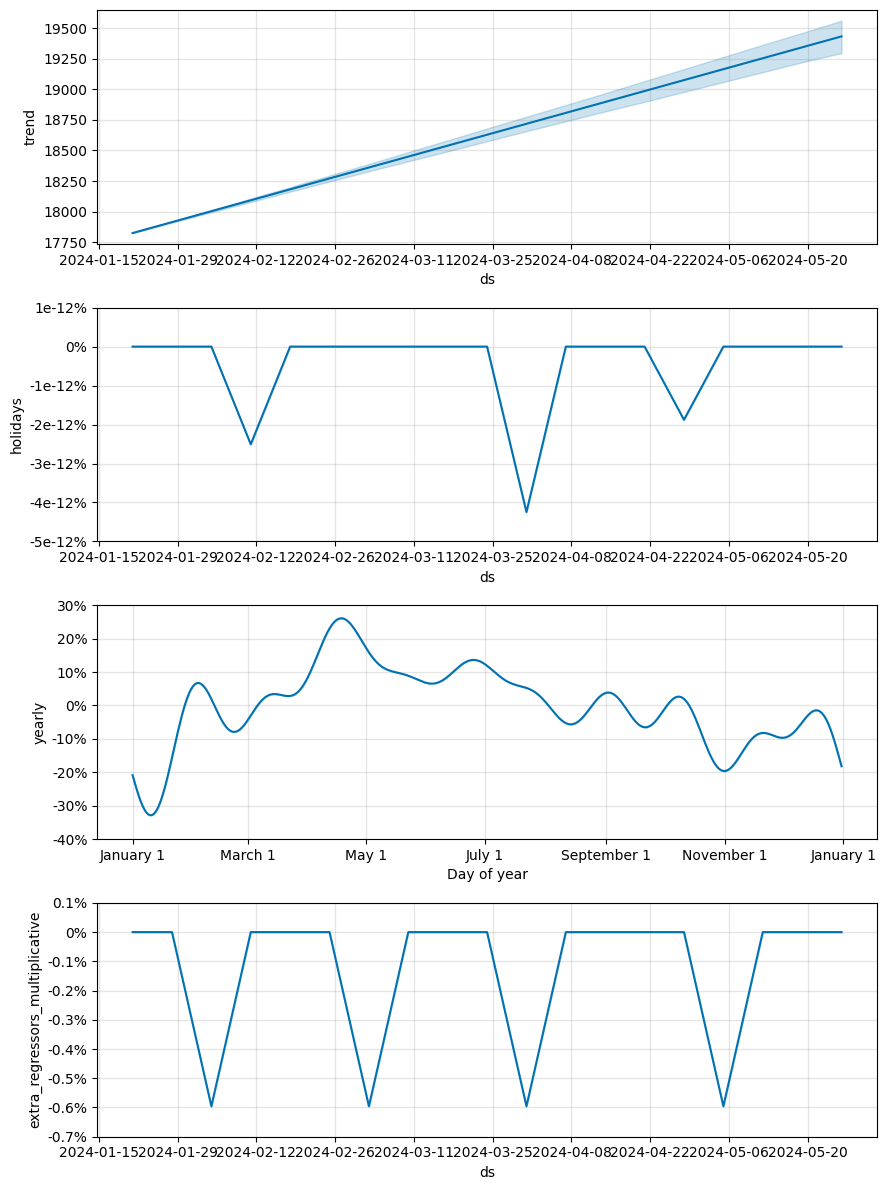

In [267]:
# Después de hacer las predicciones con el modelo
forecast = best_model.predict(df_test)

# Descompone y grafica los componentes de las predicciones (tendencia, estacionalidades, días festivos)
fig2 = best_model.plot_components(forecast)

#### Save model

In [218]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model_completo_v2.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('prophet_model_completo_v2.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

#### Feature importance

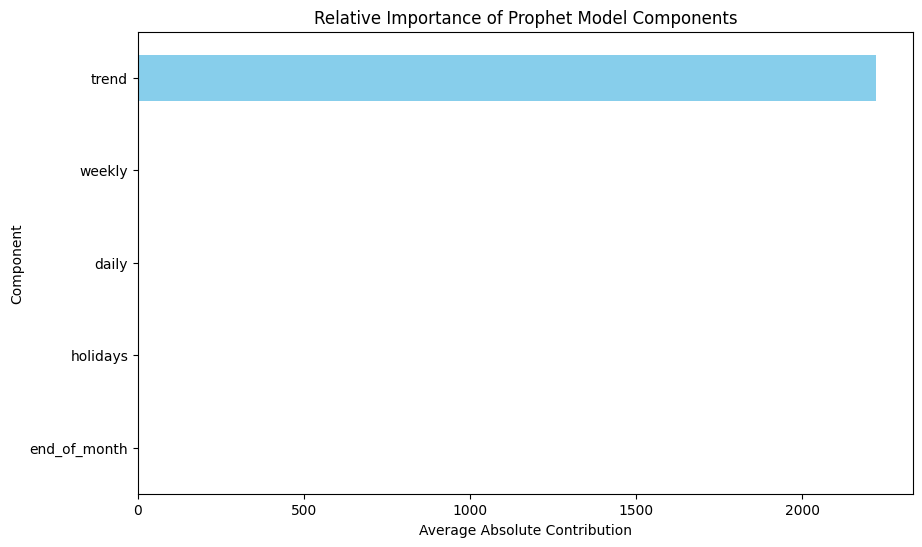

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

# Función para obtener y graficar la importancia de los componentes
def plot_feature_importance(forecast):
    # Filtrar los componentes del forecast (tendencia, estacionalidades y regresores)
    components = forecast[['trend', 'weekly', 'daily', 'holidays', 'end_of_month']]

    # Calcular la importancia relativa de cada componente (media del valor absoluto)
    components_importance = components.abs().mean()

    # Ordenar los componentes de mayor a menor importancia
    components_sorted = components_importance.sort_values(ascending=False)

    # Crear el gráfico de barras con la importancia relativa de los componentes
    plt.figure(figsize=(10, 6))
    components_sorted.plot(kind='barh', color='skyblue')  # Gráfico de barras horizontal
    plt.title('Relative Importance of Prophet Model Components')
    plt.xlabel('Average Absolute Contribution')
    plt.ylabel('Component')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que el más importante esté arriba
    plt.show()

# Después de hacer las predicciones con el modelo
forecast = best_model.predict(df_test)

# Llamar a la función para graficar la importancia de los componentes
plot_feature_importance(forecast)
